In [4]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from tqdm import tqdm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

Hasta ahora hemos ajustado el modelo usando una Regresión Logística, pero como hemos aprendido, podemos usar el Random Forest en este tipo de problemas. Los objetivos de este pair programming :

- Ajustad un modelo de Random Forest a nuestros datos.
- Calculad las métricas a nuestro nuevo modelo.
- Comparad las métricas con los modelos hechos hasta ahora. ¿Cuál es mejor?

In [5]:
df_esta = pd.read_csv("./datos/cortos_estand.csv", index_col = 0)
df_esta.head()

,satisfaction,Customer Type,Seat comfort,Food and drink,Inflight entertainment,Ease of Online booking,On-board service,Checkin service,Cleanliness,Online boarding,Age_est,Flight Distance_est,Gender_Female,Gender_Male,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,1,1,0,0,4,3,3,5,3,2,1.676424,-1.758838,1,0,0,1,0,1,0
1,1,1,0,0,2,3,4,2,3,2,0.486731,0.583063,0,1,0,1,1,0,0
2,1,1,0,0,0,2,3,4,4,2,-1.628279,0.235878,1,0,0,1,0,1,0
3,1,1,0,0,4,1,1,4,1,3,1.345954,-1.377574,1,0,0,1,0,1,0
4,1,1,0,0,3,2,2,4,2,5,2.006895,-1.664055,1,0,0,1,0,1,0


In [6]:
# separamos los datos en X e y

X1 = df_esta.drop("satisfaction", axis = 1)
y1 = df_esta["satisfaction"]

In [7]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [8]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2,4, 6, 10, 12, 14], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [9]:
gs_rf = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1) # para que no nos printee ningún mensaje en pantalla
        

In [10]:
# ajustamos el modelo que acabamos de definir en el GridSearch
# 🚨 Esta celda puede tardar en ejecutarse

gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 10, 12, 14],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             verbose=-1)

In [11]:
# saquemos ahora cual es nuestro mejor bosque

bosque = gs_rf.best_estimator_
bosque

RandomForestClassifier(max_depth=14, max_features=4, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

Por motivos...

In [12]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [13]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [14]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results = metricas(y_test, y_pred_test_rf,y_train,  y_pred_train_rf, "Random Forest")
dt_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.936994,0.936050,0.948781,0.942373,0.872888,test,Random Forest
1,0.944073,0.944407,0.953637,0.948999,0.887096,train,Random Forest


In [15]:
# igual que en la clase de decision tree, juntemos estos resultados con los obtenidos en los modelos que hemos hecho hasta ahora
# lo primero que tenemos que hacer es cargar el csv con todos los resultados que guardamos en el jupyter anterior

df_LR_DT_results = pd.read_csv("./datos/resultados_tree_log.csv", index_col = 0)
df_LR_DT_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.826970,0.836453,0.846922,0.841655,0.650954,test,Regresión logistica
1,0.831502,0.843147,0.849157,0.846141,0.659930,train,Regresión logistica
2,0.920143,0.922581,0.931057,0.926799,0.838958,test,Decission Tree Esta I
3,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Esta I
4,0.918532,0.924427,0.925631,0.925029,0.835832,test,Decision tree Esta II
5,0.926730,0.933443,0.932183,0.932812,0.852250,train,Decision tree Esta II


In [16]:
# concatenamos el csv anterior con los resultados obtenidos en este modelo

df_todos_resultados = pd.concat([dt_results, df_LR_DT_results], axis = 0)
df_todos_resultados

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.936994,0.936050,0.948781,0.942373,0.872888,test,Random Forest
1,0.944073,0.944407,0.953637,0.948999,0.887096,train,Random Forest
0,0.826970,0.836453,0.846922,0.841655,0.650954,test,Regresión logistica
1,0.831502,0.843147,0.849157,0.846141,0.659930,train,Regresión logistica
2,0.920143,0.922581,0.931057,0.926799,0.838958,test,Decission Tree Esta I
3,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree Esta I
4,0.918532,0.924427,0.925631,0.925029,0.835832,test,Decision tree Esta II
5,0.926730,0.933443,0.932183,0.932812,0.852250,train,Decision tree Esta II


In [18]:

# vamos a crearnos un dataframe, igual que hicimos en la clase anterior con la importancia de cada una de las variables incluidas en el modelo

importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
3,Inflight entertainment,0.272064
1,Seat comfort,0.163174
4,Ease of Online booking,0.108738
0,Customer Type,0.055842
5,On-board service,0.054748
8,Online boarding,0.045646
2,Food and drink,0.042121
15,Class_Business,0.038567
11,Gender_Female,0.032471
7,Cleanliness,0.030102


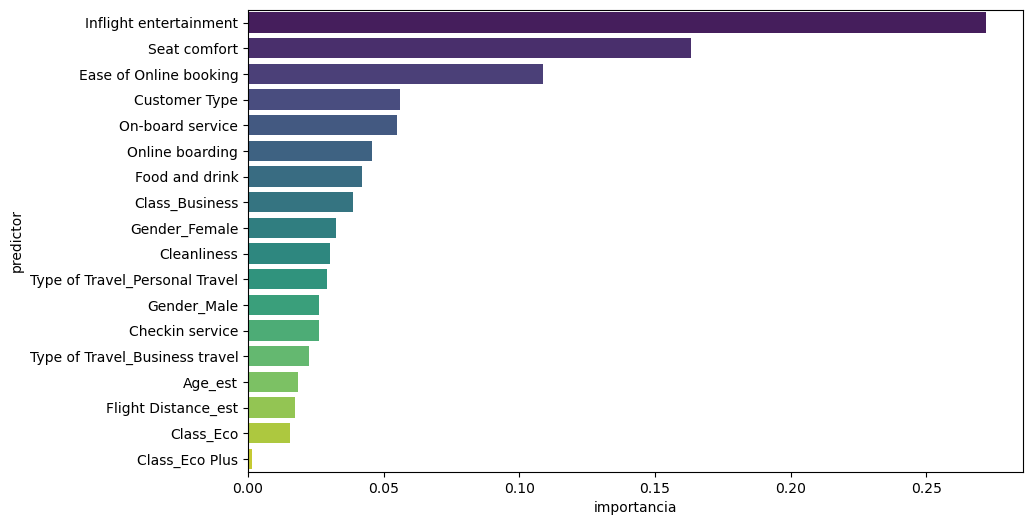

In [19]:

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

Respondiendo a nuestra 

In [20]:
df_todos_resultados.to_csv("./datos/resultados_finales_metodos.csv")

Como conclusión de los resultados obtenidos, podemos decir que para poder responder a nuestra hipótesis inicial, tendríamos que hacer un análisis de 'clusterización' con el algoritmo de KNN, ya que en el estudio actual no estamos teniendo en cuenta las implicaciones o beneficios de los loyal customers (cuantas veces viajan, que tipos de viajes hacen, qué ventajas tienen...). Otra opción sería estudiar qué es lo que influye en la satisfacción de los clientes que son de tipo loyal. En ese caso, filtraríamos nuestros datos para que solo nos quedasen aquellos de tipo loyal, y aplicaríamos el modelo para ver cuáles son los factores que más influyen en su satisfacción. 

Finalmente, con los resultados obtenidos actuales, podemos decir que el tipo de customer no es un factor muy determinante (aunque influye en poco más de 0.5, según la gráfica obtenida) en la satisfacción del cliente, aunque faltaría ver si los resultados cambian mucho quitando esa variable de las predictoras. Pero como hemos explicado anteriormente, esta no sería la forma más correcta para poder contestar a nuestra hipótesis.